In [18]:
import time
import random
import numpy as np
import matplotlib.pyplot as plt
from ucimlrepo import fetch_ucirepo 
from sklearn.model_selection import train_test_split

Dataset

In [19]:
# fetch dataset 
letter_recognition = fetch_ucirepo(id=59) 
  
# data (as pandas dataframes) 
X = letter_recognition.data.features 
y = letter_recognition.data.targets 

# Lấy ngẫu nhiên 10,000 dòng từ X và y
X_sample, _, y_sample, _ = train_test_split(X, y, train_size=10000, random_state=42)
X_train, X_test, Y_train, Y_test = train_test_split(X_sample, y_sample, test_size=0.3, random_state=42)

X_train = X_train.values.T
X_test = X_test.values.T
Y_train = Y_train.values.T
Y_test = Y_test.values.T

In [20]:
# X_train = np.loadtxt('dataset/2b/X_train.csv', delimiter = ',').T
# Y_train = np.loadtxt('dataset/2b/Y_train.csv').reshape(1, X_train.shape[1])
# X_test = np.loadtxt('dataset/2b/X_test.csv', delimiter = ',').T
# Y_test = np.loadtxt('dataset/2b/Y_test.csv').reshape(1, X_test.shape[1])

In [21]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(16, 7000)
(1, 7000)
(16, 3000)
(1, 3000)


Preprocessing Data

In [22]:
def normalize_Zscore(X):
    return (X - np.mean(X, axis=1, keepdims=True)) / np.std(X, axis=1, keepdims=True)

In [23]:
X_train = normalize_Zscore(X_train)
X_test = normalize_Zscore(X_test)

In [24]:
# Bước 1: Xác định các nhãn lớp duy nhất
classes = np.unique(Y_train)  # Tìm các nhãn lớp duy nhất trong tập huấn luyện

# Bước 2: Tạo ma trận one-hot encoding
one_hot_encoded = np.zeros((Y_train.shape[1], len(classes)))  # Ma trận (samples, số lớp)

# Điền giá trị 1 vào vị trí tương ứng với từng lớp
for i, label in enumerate(Y_train[0]):
    index = np.where(classes == label)[0][0] # Tìm vị trí của nhãn trong danh sách classes
    one_hot_encoded[i, index] = 1  # Điền giá trị 1 vào vị trí tương ứng

Y_train = one_hot_encoded.T

In [25]:
# Bước 1: Xác định các nhãn lớp duy nhất
classes = np.unique(Y_test)  # Tìm các nhãn lớp duy nhất trong tập huấn luyện

# Bước 2: Tạo ma trận one-hot encoding
one_hot_encoded = np.zeros((Y_test.shape[1], len(classes)))  # Ma trận (samples, số lớp)

# Điền giá trị 1 vào vị trí tương ứng với từng lớp
for i, label in enumerate(Y_test[0]):
    index = np.where(classes == label)[0][0] # Tìm vị trí của nhãn trong danh sách classes
    one_hot_encoded[i, index] = 1  # Điền giá trị 1 vào vị trí tương ứng

Y_test = one_hot_encoded.T

Activation Function

In [26]:
def sigmoid(Z):
    A = 1/(1+np.exp(-Z))
    return A

def softmax(z):
    expZ = np.exp(z)
    return expZ/(np.sum(expZ, 0))

def relu(Z):
    A = np.maximum(0,Z)
    return A

def tanh(x):
    return np.tanh(x)

def derivative_relu(Z):
    return np.array(Z > 0, dtype = 'float')

def derivative_tanh(x):
    return (1 - np.power(x, 2))

Initialize Parameters

In [27]:
def initialize_parameters(layer_dims):
    parameters = {}
    L = len(layer_dims)            

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) / np.sqrt(layer_dims[l-1]) #*0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
        
    return parameters

Forward Propagation

In [28]:
def forward_propagation(X, parameters, activation):
   
    forward_cache = {}
    L = len(parameters) // 2                  
    
    forward_cache['A0'] = X

    for l in range(1, L):
        forward_cache['Z' + str(l)] = parameters['W' + str(l)].dot(forward_cache['A' + str(l-1)]) + parameters['b' + str(l)]
        
        if activation == 'tanh':
            forward_cache['A' + str(l)] = tanh(forward_cache['Z' + str(l)])
        else:
            forward_cache['A' + str(l)] = relu(forward_cache['Z' + str(l)])
            

    forward_cache['Z' + str(L)] = parameters['W' + str(L)].dot(forward_cache['A' + str(L-1)]) + parameters['b' + str(L)]
    
    if forward_cache['Z' + str(L)].shape[0] == 1:
        forward_cache['A' + str(L)] = sigmoid(forward_cache['Z' + str(L)])
    else :
        forward_cache['A' + str(L)] = softmax(forward_cache['Z' + str(L)])
    
    return forward_cache['A' + str(L)], forward_cache

Cost Function

In [29]:
def compute_cost(AL, Y):
    m = Y.shape[1]
    
    if Y.shape[0] == 1:
        cost = (1./m) * (-np.dot(Y,np.log(AL).T) - np.dot(1-Y, np.log(1-AL).T))
    else:
        cost = -(1./m) * np.sum(Y * np.log(AL))
        
    cost = np.squeeze(cost)      # To make sure your cost's shape is what we expect (e.g. this turns [[17]] into 17).
    
    return cost

Backward Propagation

In [30]:
def backward_propagation(AL, Y, parameters, forward_cache, activation):
    
    grads = {}
    L = len(parameters)//2
    m = AL.shape[1]
    
    grads["dZ" + str(L)] = AL - Y
    grads["dW" + str(L)] = 1./m * np.dot(grads["dZ" + str(L)],forward_cache['A' + str(L-1)].T)
    grads["db" + str(L)] = 1./m * np.sum(grads["dZ" + str(L)], axis = 1, keepdims = True)
    
    for l in reversed(range(1, L)):
        if activation == 'tanh':
            grads["dZ" + str(l)] = np.dot(parameters['W' + str(l+1)].T,grads["dZ" + str(l+1)])*derivative_tanh(forward_cache['A' + str(l)])
        else:
            grads["dZ" + str(l)] = np.dot(parameters['W' + str(l+1)].T,grads["dZ" + str(l+1)])*derivative_relu(forward_cache['A' + str(l)])
            
        grads["dW" + str(l)] = 1./m * np.dot(grads["dZ" + str(l)],forward_cache['A' + str(l-1)].T)
        grads["db" + str(l)] = 1./m * np.sum(grads["dZ" + str(l)], axis = 1, keepdims = True)

    return grads

Update Parameters

In [31]:
def update_parameters(parameters, grads, learning_rate):

    L = len(parameters) // 2 
    
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]
        
    return parameters

Prediction

In [32]:
def predict(X, y, parameters, activation):

    m = X.shape[1]
    y_pred, caches = forward_propagation(X, parameters, activation)
    
    if y.shape[0] == 1:
        y_pred = np.array(y_pred > 0.5, dtype = 'float')
    else:
        y = np.argmax(y, 0)
        y_pred = np.argmax(y_pred, 0)
    
    return y_pred, np.sum((y_pred == y)/m)

Complete Model

In [33]:
def model_custom(X_train, Y_train, X_test, Y_test, layers_dims, learning_rate = 0.03,\
     activation = 'relu', num_iterations = 3000):

    np.random.seed(1)
    cost_train_list = []     
    cost_test_list = []
    custom_time = []

    acc_train_list = []
    acc_test_list = []         
    
    parameters = initialize_parameters(layers_dims)

    for i in range(0, num_iterations):
        start_time = time.time()

        AL_train, forward_cache_train = forward_propagation(X_train, parameters, activation)
        AL_test, forward_cache_test = forward_propagation(X_test, parameters, activation)

        cost_train = compute_cost(AL_train, Y_train)
        cost_test = compute_cost(AL_test, Y_test)

        grads = backward_propagation(AL_train, Y_train, parameters, forward_cache_train, activation)

        parameters = update_parameters(parameters, grads, learning_rate)
        
        cost_train_list.append(cost_train)
        cost_test_list.append(cost_test)

        _, acc_train = predict(X_train, Y_train, parameters, activation)
        _, acc_test = predict(X_test, Y_test, parameters, activation)

        acc_train_list.append(acc_train)
        acc_test_list.append(acc_test)

        if i % (num_iterations/10) == 0:
            print("\niter:{} \t cost train: {} \t cost test: {} \t acc_train: {} \t acc_test: {}"\
            .format(i, np.round(cost_train, 4), np.round(cost_test,4), np.round(acc_train,4), np.round(acc_test,4)))  
        
        if i % 10 == 0:
            print("==", end = '')
        
        end_time = time.time()
        custom_time.append(end_time - start_time)

    return parameters, cost_train_list, cost_test_list, custom_time, acc_train_list, acc_test_list

In [ ]:
layer_dims = [X_train.shape[0], 128, 32, Y_train.shape[0]]

lr = 0.1
iters = 1500
act='relu'
    
parameters, train_losses, test_losses, custom_time, acc_train_list, acc_test_list = \
    model_custom(X_train, Y_train, X_test, Y_test, layer_dims, \
        learning_rate = lr, activation = act, num_iterations = iters)

print(f"\nTổng thời gian chạy của Custom Model: {sum(custom_time):.2f}s")


iter:0 	 cost train: 3.3052 	 cost test: 3.2943 	 acc_train: 0.067 	 acc_test: 0.069
iter:150 	 cost train: 1.3059 	 cost test: 1.3159 	 acc_train: 0.6566 	 acc_test: 0.6427
iter:300 	 cost train: 0.9008 	 cost test: 0.939 	 acc_train: 0.7579 	 acc_test: 0.7377
iter:450 	 cost train: 0.7265 	 cost test: 0.7801 	 acc_train: 0.7974 	 acc_test: 0.7693
iter:600 	 cost train: 0.614 	 cost test: 0.6794 	 acc_train: 0.8267 	 acc_test: 0.8033
iter:750 	 cost train: 0.5317 	 cost test: 0.6065 	 acc_train: 0.8527 	 acc_test: 0.8247
iter:900 	 cost train: 0.4677 	 cost test: 0.5509 	 acc_train: 0.8697 	 acc_test: 0.844
iter:1050 	 cost train: 0.4164 	 cost test: 0.5072 	 acc_train: 0.8849 	 acc_test: 0.8527
iter:1200 	 cost train: 0.3742 	 cost test: 0.4723 	 acc_train: 0.8967 	 acc_test: 0.8673
iter:1350 	 cost train: 0.3393 	 cost test: 0.4442 	 acc_train: 0.9047 	 acc_test: 0.8703
Tổng thời gian chạy của Custom Model: 107.88s


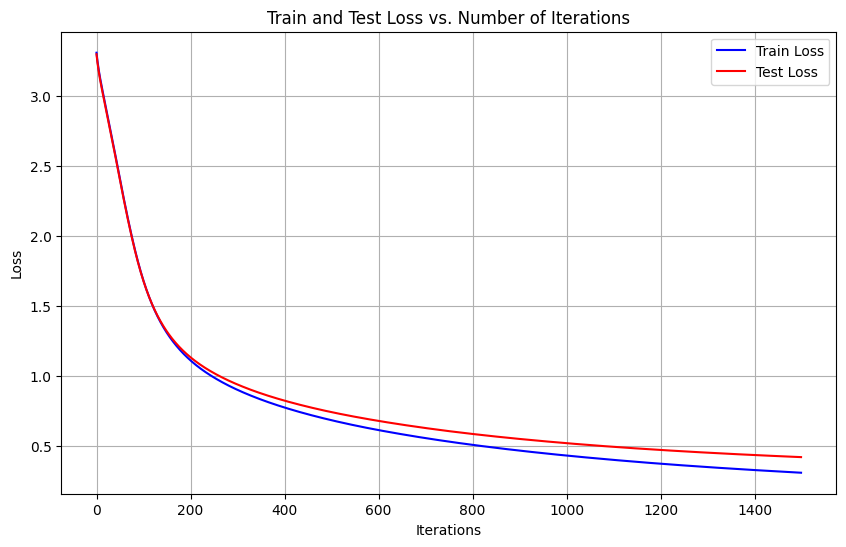

In [35]:
# Vẽ biểu đồ giữa số lần huấn luyện và hàm lỗi
plt.figure(figsize=(10,6))
plt.plot(range(iters), train_losses, label='Train Loss', color='blue')
plt.plot(range(iters), test_losses, label='Test Loss', color='red')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Train and Test Loss vs. Number of Iterations')
plt.legend()
plt.grid(True)
plt.show()

Tensorflow

In [36]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import History
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import Callback
import keras
from keras import layers

In [37]:
X_train = X_train.T
X_test = X_test.T
Y_train = Y_train.T
Y_test = Y_test.T

In [38]:
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((7000, 16), (3000, 16), (7000, 26), (3000, 26))

In [39]:
# Tạo callback tùy chỉnh để lưu thời gian sau mỗi epoch
class TimeHistory(Callback):
    def on_train_begin(self, logs=None):
        self.epoch_times = []  # Lưu thời gian mỗi epoch

    def on_epoch_begin(self, epoch, logs=None):
        self.start_time = time.time()  # Bắt đầu đo thời gian

    def on_epoch_end(self, epoch, logs=None):
        epoch_time = time.time() - self.start_time  # Tính thời gian epoch
        self.epoch_times.append(epoch_time)  # Lưu vào danh sách

In [40]:
# Khởi tạo callback
time_callback = TimeHistory()

In [ ]:
# Khởi tạo mô hình
model = keras.Sequential()
model.add(keras.Input(shape=(X_train.shape[1],)))
model.add(layers.Dense(128, activation="relu"))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(Y_train.shape[1], activation='sigmoid'))
optimizer = SGD(learning_rate=lr)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Huấn luyện mô hình và lưu lịch sử
history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), \
    epochs=iters, callbacks=[time_callback])

Epoch 1/1500
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2693 - loss: 2.6576 - val_accuracy: 0.6543 - val_loss: 1.2263
Epoch 2/1500
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6748 - loss: 1.1219 - val_accuracy: 0.7363 - val_loss: 0.9019
Epoch 3/1500
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7477 - loss: 0.8133 - val_accuracy: 0.7753 - val_loss: 0.7382
Epoch 4/1500
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8016 - loss: 0.6702 - val_accuracy: 0.8050 - val_loss: 0.6432
Epoch 5/1500
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8304 - loss: 0.5740 - val_accuracy: 0.8070 - val_loss: 0.6193
Epoch 6/1500
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8558 - loss: 0.4928 - val_accuracy: 0.8470 - val_loss: 0.5104
Epoch 7/1500
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8695 - loss: 0.4488 - val_accuracy: 0.8550 - val_loss: 0.4800
Epoch 8/1500
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8845 - loss: 0.3924 - 

In [42]:
# Lấy danh sách thời gian sau mỗi epoch
tensorflow_time = time_callback.epoch_times
print("Thời gian mỗi epoch:", tensorflow_time)

# Tổng thời gian chạy
total_time = np.sum(tensorflow_time)
print(f"Tổng thời gian huấn luyện: {total_time:.2f} giây")

Thời gian mỗi epoch: [0.9252743721008301, 0.28305530548095703, 0.3021702766418457, 0.3169991970062256, 0.29113221168518066, 0.3267526626586914, 0.3149988651275635, 0.2840256690979004, 0.2628648281097412, 0.27970147132873535, 0.2669990062713623, 0.2678394317626953, 0.2602963447570801, 0.2722296714782715, 0.2937741279602051, 0.3200223445892334, 0.2654836177825928, 0.27500104904174805, 0.27299952507019043, 0.29294681549072266, 0.26260876655578613, 0.26462244987487793, 0.2850000858306885, 0.28684067726135254, 0.2650003433227539, 0.26837635040283203, 0.29880309104919434, 0.27034807205200195, 0.26049351692199707, 0.26069140434265137, 0.2982308864593506, 0.3388402462005615, 0.25835132598876953, 0.24699139595031738, 0.2883260250091553, 0.25452303886413574, 0.2547144889831543, 0.24967026710510254, 0.26999926567077637, 0.28342223167419434, 0.24838018417358398, 0.26465630531311035, 0.3159964084625244, 0.3280034065246582, 0.28890085220336914, 0.2773404121398926, 0.2941112518310547, 0.3043572902679

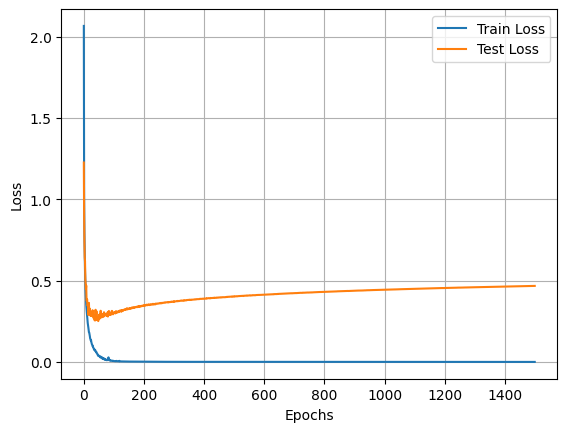

In [43]:
# Vẽ biểu đồ hàm lỗi sau khi huấn luyện
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()  
plt.grid(True)
plt.show()

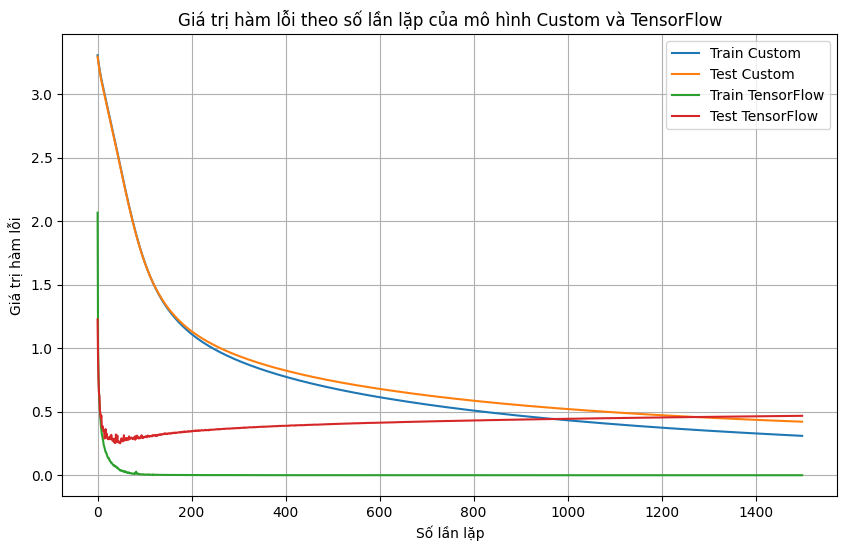

In [44]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Custom')
plt.plot(test_losses, label='Test Custom')
plt.plot(history.history['loss'], label='Train TensorFlow')
plt.plot(history.history['val_loss'], label='Test TensorFlow')
plt.xlabel("Số lần lặp")
plt.ylabel("Giá trị hàm lỗi")
plt.legend()
plt.grid()
plt.title("Giá trị hàm lỗi theo số lần lặp của mô hình Custom và TensorFlow")   
plt.show()

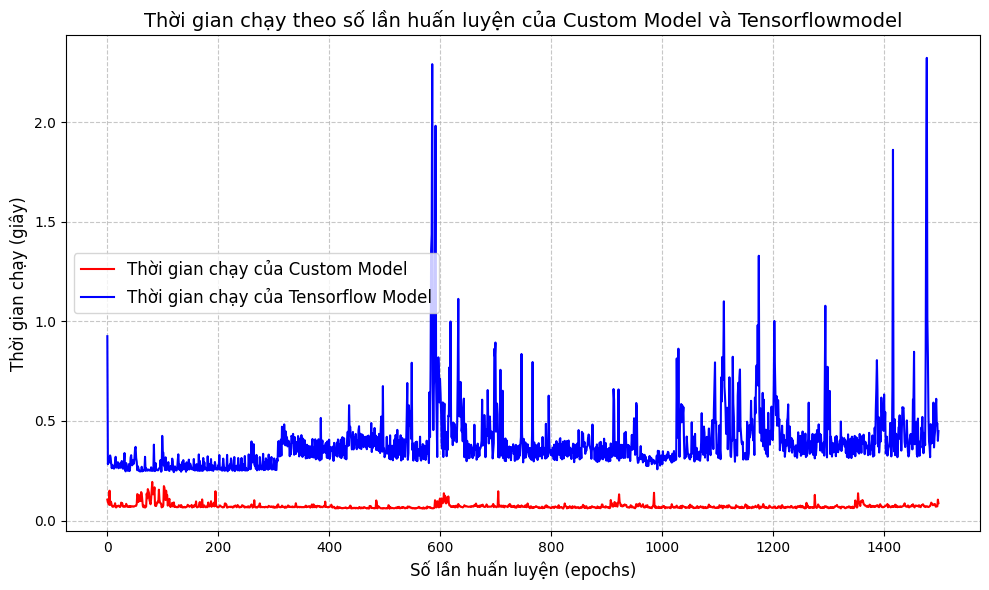

In [45]:
# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
plt.plot(range(iters), custom_time, color='red', label='Thời gian chạy của Custom Model')
plt.plot(range(iters), tensorflow_time, color='blue', label='Thời gian chạy của Tensorflow Model')
plt.xlabel("Số lần huấn luyện (epochs)", fontsize=12)
plt.ylabel("Thời gian chạy (giây)", fontsize=12)
plt.title("Thời gian chạy theo số lần huấn luyện của Custom Model và Tensorflowmodel", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.7)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

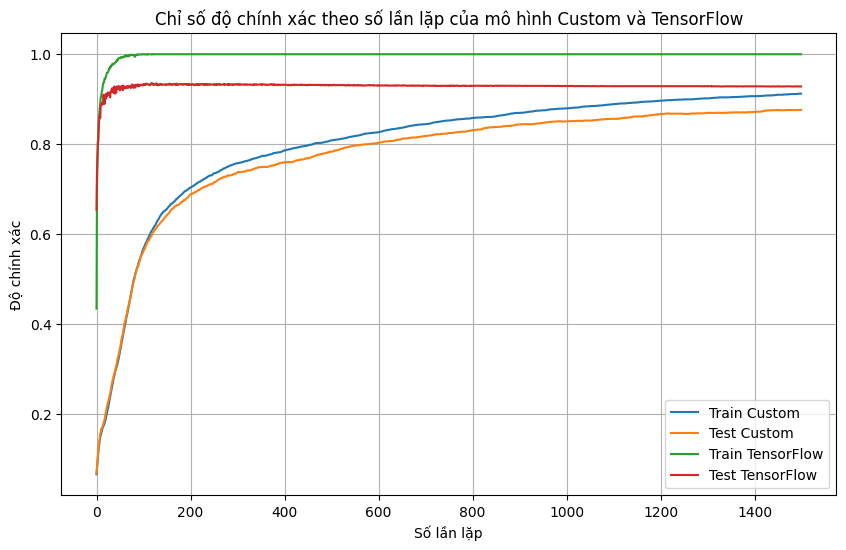

In [46]:
plt.figure(figsize=(10, 6))
plt.plot(acc_train_list, label='Train Custom')
plt.plot(acc_test_list, label='Test Custom')
plt.plot(history.history['accuracy'], label='Train TensorFlow')
plt.plot(history.history['val_accuracy'], label='Test TensorFlow')
plt.xlabel("Số lần lặp")
plt.ylabel("Độ chính xác")
plt.legend()
plt.grid()
plt.title("Chỉ số độ chính xác theo số lần lặp của mô hình Custom và TensorFlow")   
plt.show()